In [1]:
import numpy as np
%matplotlib inline

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


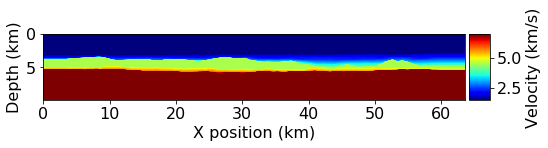

In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity
from sympy import sqrt

# Define a physical size
shape = (1273,311)  # Number of grid point (nx, nz)
spacing = (50.0, 32.0)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
#v = np.empty(shape, dtype=np.float32)
#rho=np.empty(shape, dtype=np.float32)
f= open('GM_vel_XL7796.bin', 'rb')
vel = np.fromfile(f, dtype=np.float32)
vel = np.reshape(vel, shape)
vel*=1./1000
f= open('GM_den_XL7796.bin', 'rb')
den = np.fromfile(f, dtype=np.float32)
den = np.reshape(den, shape)

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=vel, rho=den, origin=origin, shape=shape, spacing=spacing,
              space_order=16, nbpml=80)

plot_velocity(model)

In [3]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 20000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing
print(dt)
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print(time_range.num)

1.92
10418


[[3.66e+04 8.00e+00]]


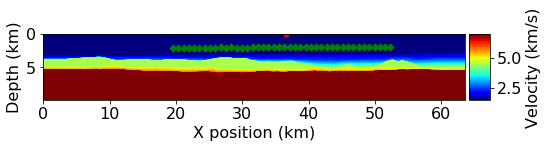

In [4]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource, Receiver

f0 = 0.004  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, :] = 36600.
src.coordinates.data[0, -1] = 8.  # Depth is 8m
print(src.coordinates.data)

rec_coords = np.loadtxt('7796.txt')
#rec = Receiver(name='rec', grid=model.grid, npoint=shape[0], time_range=time_range)
rec = Receiver(name='rec', grid=model.grid, npoint=len(rec_coords), time_range=time_range)

rec.coordinates.data[:] = rec_coords[:]
#plot_velocity(model, source=src.coordinates.data,receiver=rec.coordinates.data)

# Prescribe even spacing for receivers along the x-axis
#rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=shape[0])
#rec.coordinates.data[:, 1] = rec_coords[:]  # Depth is 20m
plot_velocity(model, source=src.coordinates.data,receiver=rec.coordinates.data)

In [5]:
from devito import *

rho = Function ( name =" rho", grid =model.grid, space_order=16) # Physical parameter
inv_rho=Function ( name =" inv_rho", grid =model.grid, space_order =16) # Physical parameter

inv_rho.data[:]=1/np.sqrt(model.rho.data[:])
rho.data[:]=np.sqrt(model.rho.data[:])
pde = rho*inv_rho.laplace
pde

(Derivative( inv_rho(x, y), (x, 2)) + Derivative( inv_rho(x, y), (y, 2)))* rho(x, y)

In [6]:
stencil=Eq(rho,pde)
op=Operator([stencil])()

Operator `Kernel` run in 0.02 s


In [7]:
# Define the wavefield with the size of the model and the time dimension
q = TimeFunction(name="q", grid=model.grid, time_order=2, space_order=16)
pde=model.m*q.dt2-q.laplace+rho*q+ model.damp * q.dt
stencil=Eq(q.forward,solve(pde,q.forward))

src_term= src.inject(field=q.forward, expr=src*dt**2/model.m)
rec_term= rec.interpolate(expr=q.forward)

In [8]:
def mirror(field, model, dim_fs):
    """
    Free surface expression. Mirrors the negative wavefield above the sea level
    :return: Symbolic equation of the free surface
    """
    dim = field.dimensions[-1]
    print(dim)
    next = field.forward
    return [Eq(next.subs({dim: dim_fs}), - next.subs({dim: 2*model.nbpml - dim_fs}))]

In [9]:
# Mirror
x, z = model.grid.dimensions
print(z)
print(z.name)
dim_fs = SubDimension.left(name='abc_'+ z.name + '_left', parent=z, thickness=model.nbpml)
print(dim_fs)
fs = mirror(q, model, dim_fs)

y
y
abc_y_left
y


In [10]:
#op=Operator([stencil]+src_term+fs+rec_term)
op=Operator([stencil]+src_term+rec_term)
op(time=time_range.num-1,dt=dt)

Operator `Kernel` run in 195.22 s


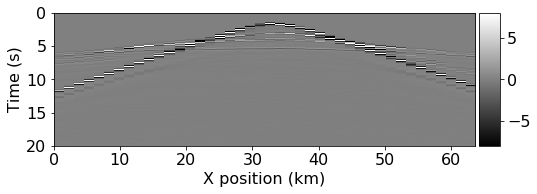

In [11]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)

In [12]:
print(rec.data.shape)
resampled=rec.resample(dt=4.)
print(resampled.shape)

(10418, 42)
(5002, 42)


In [13]:
g= open('2D_shot_variable_density.file', 'wb')
np.transpose(resampled.data[:-1,:]).astype('float32').tofile(g)

In [16]:
rec.data[:]=1.0+np.random.random(rec.data.shape)*2.0
print(rec.data[0,:])

[1.3829166 1.0750417 1.1351497 2.6778347 1.4596198 1.2397124 2.59645
 2.0381358 2.8146365 1.7451886 2.7467644 2.8604393 2.5302377 1.0992681
 1.1932424 1.1390966 2.9065325 1.1973759 2.0848632 2.6792529 1.6727574
 2.295973  1.4710854 2.991381  2.0381503 1.6407732 2.9358432 1.2672856
 2.0901134 1.848878  2.7943304 1.6383727 1.547793  1.8289859 1.5565958
 2.0268877 1.0737966 1.8492522 2.0354497 2.4398127 2.417297  1.0382813]


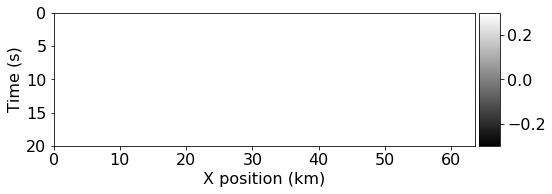

In [15]:
plot_shotrecord(rec.data, model, t0, tn)